                                            filename                  one two  \
0  pic2--1----Copy_jpg.rf.f5b1e7ad7f01614baff3f8f...  [ 246 162 118 149 ]  []   
1  pic2--1----Copy_jpg.rf.62e61bd99986533751beefd...   [ 120 66 163 144 ]  []   
2  pic3--1----Copy_jpg.rf.871e42f78d7eba3a4411f9f...                   []  []   
3  pic1--1-_jpg.rf.fbb90f0775f97ba442805ebc242f3e...   [ 137 162 126 96 ]  []   
4  pic2--1----Copy_jpg.rf.5b238c4b7cea7d35d54cea1...   [ 70 122 104 138 ]  []   

  three four                                five  \
0    []   []                   [ 215 25 95 126 ]   
1    []   []                   [ 1 125 129 119 ]   
2    []   []  [ 110 125 135 115;1 143 110 110  ]   
3    []   []                  [ 267 86 114 102 ]   
4    []   []                  [ 108 280 84 118 ]   

                                  six seven eight nine ten  
0   [ 132 170 117 138; 95 36 105 116]    []    []   []  []  
1  [ 146 182 153 141;21 236 128 126 ]    []    []   []  []  
2  [ 132 235 138 

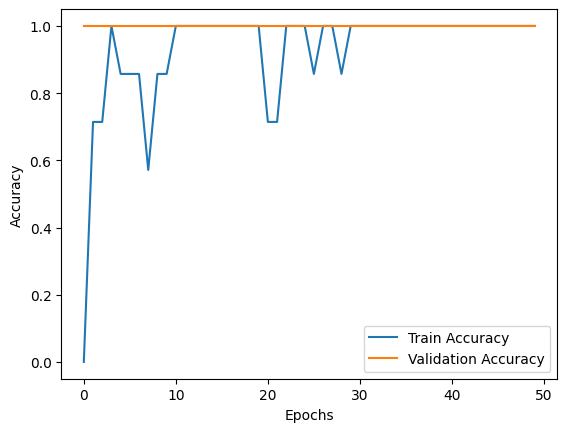

1/1 [==============================] - 0s 211ms/step
Predicted Class: [1], Confidence: 1.00


In [6]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load Data
excel_file = 'data/fulldata.xlsx'  # Excel file path
data_dir = 'data/images'  # Directory where images are stored

# Read Excel File
data = pd.read_excel(excel_file, sheet_name='Sheet1')

# Verify data structure
print(data.head())

# Extract File Names and Class Labels
file_names = data['filename'].values
class_labels = data[['one', 'two', 'three', 'four', 'five', 
                     'six', 'seven', 'eight', 'nine', 'ten']].values

# Ensure class labels are in single-label format (modify for multi-label if needed)
class_indices = class_labels.argmax(axis=1)

# Split Dataset into Training, Validation, and Testing
train_files, test_files, train_labels, test_labels = train_test_split(
    file_names, class_indices, test_size=0.2, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, random_state=42)

# Helper Function to Load and Preprocess Images
def load_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def create_dataset(file_list, labels, data_dir):
    images = [load_image(os.path.join(data_dir, file)) for file in file_list]
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

# Create TensorFlow Datasets
x_train, y_train = create_dataset(train_files, train_labels, data_dir)
x_val, y_val = create_dataset(val_files, val_labels, data_dir)
x_test, y_test = create_dataset(test_files, test_labels, data_dir)

# Convert Labels to Categorical
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20)
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# Train Model
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=(x_val, y_val))

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Save Model
model.save('weld_seam_classifier.h5')

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict on New Data
def predict_image(file_path, model):
    img = load_image(file_path)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img)
    predicted_class = predictions.argmax(axis=1)
    confidence = predictions.max(axis=1)
    return predicted_class, confidence

import numpy as np

example_image = os.path.join(data_dir, 'C:/nnflproject/test/shapenew.jpg')
predicted_class, confidence = predict_image(example_image, model)

confidence = np.max(confidence)  
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")